<a href="https://colab.research.google.com/github/saif-mahmud/hierarchical-attention-HAR/blob/master/MEx_HSA_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!nvidia-smi

Fri Aug 14 13:07:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Download

In [3]:
!mkdir data
!wget -q -O data/clean_mex_data.csv https://www.dropbox.com/s/h22cg25jszu2360/clean_mex_data.csv?dl=1

mkdir: cannot create directory ‘data’: File exists


In [4]:
df = pd.read_csv('data/clean_mex_data.csv')

In [5]:
FEATURES = ['act_x', 'act_y', 'act_z','acw_x', 'acw_y', 'acw_z']
FEATURES_THIGH = ['act_x', 'act_y', 'act_z']
FEATURES_WRIST = ['acw_x', 'acw_y', 'acw_z']
LABELS = 'activity'

In [6]:
def get_activity_dict(novel_classes:list):
    activity_map = {1:'Knee Rolling',2:'Bridging', 3:'Pelvic tilt', 4:'The Clam',5:'Repeated Extension in Lying', 6:'Prone punches',7:'Superman'}
    novel_map = dict()
    for activity_class in novel_classes:
        novel_map[activity_class] = activity_map[activity_class]
        activity_map.pop(activity_class)
        
    return activity_map, novel_map

In [7]:
NOVEL_CLASSES = [3, 6]

In [8]:
activity_map, novel_map = get_activity_dict(NOVEL_CLASSES)

In [9]:
print(activity_map)
print(novel_map)

{1: 'Knee Rolling', 2: 'Bridging', 4: 'The Clam', 5: 'Repeated Extension in Lying', 7: 'Superman'}
{3: 'Pelvic tilt', 6: 'Prone punches'}


### scaling

In [10]:
df[FEATURES] = df[FEATURES]/100
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [11]:
holdout_data = df.loc[df['activity'].isin(NOVEL_CLASSES)]
novel_data = holdout_data.copy().reset_index(drop=True)

df = df.drop(holdout_data.copy().index)
df = df.reset_index(drop=True)

In [12]:
def add_noise(df:pd.DataFrame, feat_list:list, num_features=6, num_augmented_samples=4, mu=0.0, sigma=0.5):
    df_aug = df.copy(deep=True)

    for _ in range(num_augmented_samples):
        noise = np.random.normal(mu, sigma, [df.shape[0], num_features])

        df_noise = df[['act_x', 'act_y', 'act_z', 'acw_x', 'acw_y', 'acw_z']].copy(deep=True)
        df_noise = df_noise + noise

        df_noise['timestamp'] = df['timestamp']
        df_noise['subject_id'] = df['subject_id']
        df_noise['activity'] = df['activity']

        df_noise = df_noise[df.columns]

        df_aug = pd.concat([df_aug, df_noise], ignore_index=True)

    return df_aug

In [13]:
df.shape

(884385, 9)

In [14]:
novel_data.shape

(345454, 9)

### Train test split

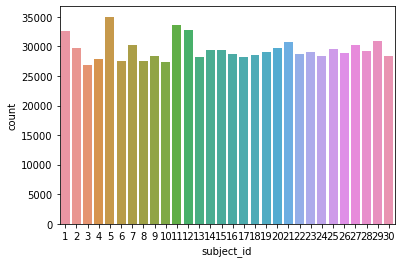

In [15]:
sns.countplot(x='subject_id', data=df)

In [16]:
train_sub = list(range(6,31))
# train_sub.extend(list(range(26,31)))
val_sub = list(range(1,6))
test_sub = list(range(1,6))

In [17]:
train_df = df[df['subject_id'].isin(train_sub)]
val_df =  df[df['subject_id'].isin(val_sub)]
test_df = df[df['subject_id'].isin(test_sub)]

In [18]:
train_df = add_noise(train_df, feat_list=FEATURES)

## windowing

In [19]:
WINDOW_SIZE=2000
STRIDE = 300

In [20]:
def create_windowed_dataset(df, features= FEATURES, class_label = LABELS, window_size=2000, stride = 300):
    X = df[features].values
    y = df[class_label].values
    segments = []
    labels = []

    seg_start= 0
    seg_end = window_size
    while seg_end <= len(X):
        if len(np.unique(y[seg_start:seg_end])) == 1: #valid-window
            segments.append(X[seg_start:seg_end])
            labels.append(y[seg_start]) # doesn't matter all same labels

            seg_start += stride
            seg_end = seg_start + window_size

        else: #mixed- discard last few samples, move start to the new activity
            current_label = y[seg_start]
            for i in range(seg_start, seg_end):
                if y[i] != current_label:
                    seg_start = i
                    seg_end = seg_start + window_size
                    break

    return np.asarray(segments).astype(np.float32), np.asarray(labels)

In [21]:
X_train, y_train = create_windowed_dataset(train_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
X_val, y_val = create_windowed_dataset(val_df, FEATURES,window_size=WINDOW_SIZE, stride = STRIDE)
X_test, y_test = create_windowed_dataset(test_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)

In [22]:
X_holdout, y_holdout = create_windowed_dataset(novel_data, FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)

In [23]:
N_WINDOW = 10
N_TIMESTEP = 200

In [24]:
X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 6))
X_val = X_val.reshape((X_val.shape[0], N_WINDOW, N_TIMESTEP, 6))
X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 6))
X_holdout = X_holdout.reshape((X_holdout.shape[0], N_WINDOW, N_TIMESTEP, 6))

y_train = tf.keras.utils.to_categorical(y_train-1)
y_val = tf.keras.utils.to_categorical(y_val-1)
y_test = tf.keras.utils.to_categorical(y_test-1)
y_holdout = tf.keras.utils.to_categorical(y_holdout-1)

In [25]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

print(X_holdout.shape)
print(y_holdout.shape)

(8375, 10, 200, 6)
(8375, 7)
(354, 10, 200, 6)
(354, 7)
(354, 10, 200, 6)
(354, 7)
(783, 10, 200, 6)
(783, 6)


## Attention Model

In [26]:
class AggregateAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(AggregateAttention, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.d_model = d_model
        self.query = self.add_weight("learned_query",
                                     shape=[1, 1, self.d_model],
                                     initializer=tf.keras.initializers.Orthogonal())  
    
    def call(self, v, k):
        batched_query = tf.tile(self.query, [tf.shape(v)[0],1,1])
        output, attention_weights = self.mha(v, k, batched_query, mask=None)
        output = tf.squeeze(output, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=2)
        return output, attention_weights

### Self Attention

In [27]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model, include_dropout=True, dropout_rate=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [28]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [29]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=True)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [30]:
class SelfAttentionBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(SelfAttentionBlock, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [31]:
class CombinedSensorAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CombinedSensorAttention, self).__init__()
        self.agr_attn = AttentionWithContext(return_attention=True)
    
    def call(self, x):
        x = tf.concat(x, axis=1)
        x, attn_score = self.agr_attn(x)
        return x, attn_score

In [32]:
class CombinedSensorSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate, concat=True):
        super(CombinedSensorSelfAttention, self).__init__()
        self.concat = concat
        self.agr_attn = AggregateAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x):
        if self.concat:
            x = tf.concat(x, axis=1)
        x, attn_score = self.agr_attn(x, x)
        x = self.dropout1(x)
        ffn_output = self.ffn(x)  # (batch_size, d_model)
        ffn_output = self.dropout2(ffn_output)
        out = self.layernorm(ffn_output + x)  # (batch_size, d_model)
        return out, attn_score

In [33]:
class DataTransform(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(DataTransform, self).__init__()
        # self.ln = tf.keras.layers.LayerNormalization()
        self.conv_1d = tf.keras.layers.Conv1D(d_model, 1, activation='relu')
    
    def call(self, x):
        # x = self.ln(x)
        x = self.conv_1d(x)
        return x

In [34]:
class ModalityEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_timesteps, d_model, num_heads, dff, num_sa_blocks=2, dropout_rate=0.1):
        super(ModalityEncoderBlock, self).__init__()
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.look_ahead_mask = create_look_ahead_mask(n_timesteps)
        self.data_transform = DataTransform(d_model)
        self.pe = PositionalEncoding(n_timesteps, d_model, dropout_rate=dropout_rate)
        self.num_sa_blocks = num_sa_blocks
        self.self_attn_blocks = [ SelfAttentionBlock(d_model, num_heads, dff, dropout_rate)
                                        for _ in range(self.num_sa_blocks)]
        # self.agr_attn = AttentionWithContext(return_attention=True)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.data_transform(x)
        x = self.pe(x)
        for i in range(self.num_sa_blocks):
            # x = self.self_attn_blocks[i](x, mask=self.look_ahead_mask)
            x = self.self_attn_blocks[i](x)
        # x, attn_score = self.agr_attn(x)
        # return x, attn_score
        return x


    # def compute_output_shape(x, input_shape):
    #     return tf.TensorShape([input_shape, self.d_model])

In [35]:
def get_modality_encoder(modality_indices, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    num_modality = len(modality_indices)-1
    inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
    attn_scores = []
    modality_outputs = []
    for i in range(num_modality):
            modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
            modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
            modality_outputs.append(modality_x)
    model = tf.keras.Model(inputs=inputs, outputs=modality_outputs)
    return model

In [36]:
class MultiWindowEncoder(tf.keras.layers.Layer):
    def __init__(self, modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1):
        super(MultiWindowEncoder, self).__init__()
        self.n_window = n_window
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.window_encoder = get_modality_encoder(modality_indices,n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs, d_model=d_model, num_heads = num_heads, dff=dff, dropout_rate=dropout_rate)
        self.combined_sensor_attn = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        feature_dim = tf.shape(x)[-1]
        x = tf.reshape(x, (-1, self.n_timesteps, feature_dim)) # all sessions in batch dim
        x = self.window_encoder(x)
        x, attn_scores = self.combined_sensor_attn(x)
        x = tf.reshape(x, (batch_size, -1, self.d_model))
        attn_scores = tf.reshape(attn_scores, (batch_size, -1, self.n_timesteps))
        return x, attn_scores

In [37]:
# def get_modality_model(modality_indices, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
#     num_modality = len(modality_indices)-1
#     inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
#     attn_scores = []
#     modality_outputs = []
#     for i in range(num_modality):
#             modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
#             # modality_x, attn_score = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=nh, dff=dff, num_sa_blocks=2)(modality_x)
#             # modality_outputs.append(modality_x)
#             modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
#             modality_outputs.append(modality_x)
#             # attn_score = tf.keras.layers.Flatten() (attn_score)
#             # attn_scores.append(attn_score)
#     x, _ = CombinedSensorAttention() (modality_outputs)
#     predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
#     model = tf.keras.Model(inputs=inputs, outputs=predictions)
#     return model

In [38]:
def get_modality_model_w_time_hierarchy(modality_indices,n_window, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(n_window, n_timesteps,n_features,))
    x, _ = MultiWindowEncoder(modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1) (inputs)
    x = ModalityEncoderBlock(n_timesteps=n_window, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(x)
    x, _ = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate, concat=True) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

In [39]:
def get_hierarchical_vae_model(modality_indices,n_window, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(n_window, n_timesteps,n_features,))
    x, _ = MultiWindowEncoder(modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1) (inputs)
    x = ModalityEncoderBlock(n_timesteps=n_window, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(x)
    x, _ = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate, concat=False) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

## Traiining

In [40]:
tf.keras.backend.clear_session()

n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
model = get_modality_model_w_time_hierarchy([0,3,6],n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics='accuracy')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 200, 6)]      0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 250048    
_________________________________________________________________
modality_encoder_block_2 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 49856     
_________________________________________________________________
dense_48 (Dense)             (None, 7)                 455       
Total params: 404,359
Trainable params: 404,359
Non-trainable params: 0
_________________________________________________________________


In [41]:
verbose, epochs, batch_size = 1, 40, 128
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,verbose=1, mode='max')
#mcp_save = ModelCheckpoint('test_3_best.hdf5', save_best_only=True, monitor='val_acc', mode='max')
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              verbose=verbose, validation_data=(X_val, y_val))

Epoch 1/40
66/66 [==============================] - 44s 660ms/step - loss: 1.5002 - accuracy: 0.3765 - val_loss: 0.7992 - val_accuracy: 0.6356
Epoch 2/40
66/66 [==============================] - 43s 650ms/step - loss: 0.4603 - accuracy: 0.8186 - val_loss: 0.6218 - val_accuracy: 0.8362
Epoch 3/40
66/66 [==============================] - 43s 658ms/step - loss: 0.2025 - accuracy: 0.9306 - val_loss: 0.7238 - val_accuracy: 0.8136
Epoch 4/40
66/66 [==============================] - 44s 668ms/step - loss: 0.1110 - accuracy: 0.9672 - val_loss: 0.8423 - val_accuracy: 0.8164
Epoch 5/40
66/66 [==============================] - 44s 667ms/step - loss: 0.0737 - accuracy: 0.9770 - val_loss: 0.8685 - val_accuracy: 0.7938
Epoch 6/40
66/66 [==============================] - 45s 676ms/step - loss: 0.0479 - accuracy: 0.9878 - val_loss: 0.7637 - val_accuracy: 0.8475
Epoch 7/40
66/66 [==============================] - 46s 690ms/step - loss: 0.0315 - accuracy: 0.9933 - val_loss: 0.7700 - val_accuracy: 0.8644

In [42]:
pred = model.predict(X_test, batch_size=128)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), target_names=list(activity_map.values())))

                             precision    recall  f1-score   support

               Knee Rolling       1.00      0.57      0.72        60
                   Bridging       0.84      0.85      0.84        80
                   The Clam       0.74      1.00      0.85        76
Repeated Extension in Lying       0.82      0.80      0.81        70
                   Superman       1.00      1.00      1.00        68

                   accuracy                           0.85       354
                  macro avg       0.88      0.84      0.85       354
               weighted avg       0.87      0.85      0.85       354



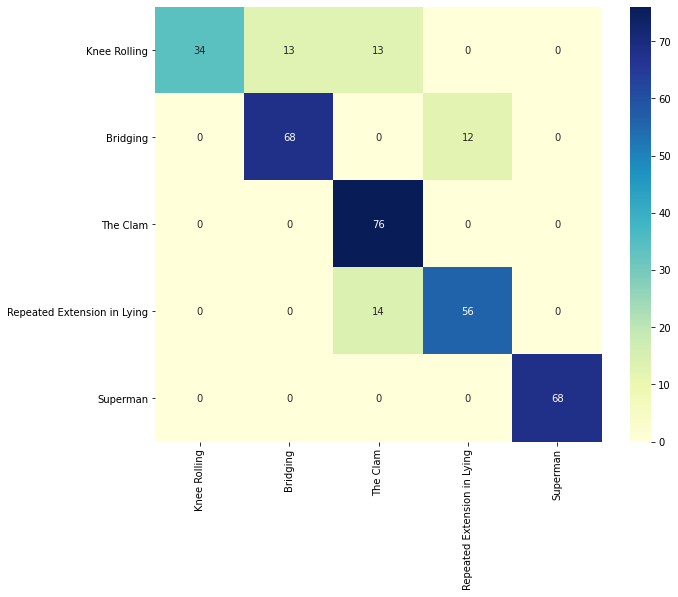

In [45]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [46]:
for l in model.layers:
    print(l.name)

input_1
multi_window_encoder
modality_encoder_block_2
combined_sensor_self_attention_1
dense_48


In [47]:
hierarchical_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('combined_sensor_self_attention_1').output, name='hierarchical_encoder')
hierarchical_model.trainable = False

In [48]:
hierarchical_model.summary()

Model: "hierarchical_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 200, 6)]      0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 250048    
_________________________________________________________________
modality_encoder_block_2 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 49856     
Total params: 403,904
Trainable params: 0
Non-trainable params: 403,904
_________________________________________________________________


## VAE [Novelty Detection]

In [49]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim=16, intermediate_dim=32, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, original_dim, intermediate_dim=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        base_model,
        original_dim,
        intermediate_dim=32,
        latent_dim=16,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.base_model = base_model
        
        self.original_dim = original_dim
        
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        inputs, _ = self.base_model(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            data, _ = self.base_model(data)
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

            reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(data, reconstructed))
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [50]:
hsa_vae = VariationalAutoEncoder(base_model=hierarchical_model, original_dim=64)

In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
hsa_vae.compile(optimizer)    

In [52]:
vae_history = hsa_vae.fit(X_train, epochs=35, batch_size=128)

Epoch 1/35
66/66 [==============================] - 15s 234ms/step - loss: 1.3986 - reconstruction_loss: 1.2082 - kl_loss: 0.1904
Epoch 2/35
66/66 [==============================] - 15s 233ms/step - loss: 1.1248 - reconstruction_loss: 1.0999 - kl_loss: 0.0249
Epoch 3/35
66/66 [==============================] - 15s 233ms/step - loss: 1.0673 - reconstruction_loss: 1.0512 - kl_loss: 0.0160
Epoch 4/35
66/66 [==============================] - 15s 233ms/step - loss: 1.0429 - reconstruction_loss: 1.0305 - kl_loss: 0.0123
Epoch 5/35
66/66 [==============================] - 15s 235ms/step - loss: 1.0297 - reconstruction_loss: 1.0171 - kl_loss: 0.0127
Epoch 6/35
66/66 [==============================] - 16s 237ms/step - loss: 1.0203 - reconstruction_loss: 1.0031 - kl_loss: 0.0172
Epoch 7/35
66/66 [==============================] - 16s 237ms/step - loss: 1.0079 - reconstruction_loss: 0.9807 - kl_loss: 0.0271
Epoch 8/35
66/66 [==============================] - 16s 237ms/step - loss: 0.9869 - recons

In [53]:
novel_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout))

In [70]:
def novelty_eval(init_threshold:float, X_holdout, novel_rec_loss):
    print('Optimized Reconstruction Loss :', init_threshold)
    print('Min Reconstruction Loss in Holdout Data :', min(novel_rec_loss.numpy()))
    thresh_vals = list(np.arange(0.25, (init_threshold + 0.2), 0.01))

    print('\nRec. Error Threshold || Novelty Detection Accuracy')

    for t in reversed(thresh_vals): 
        reconstruction_loss_threshold = tf.constant([float(t)])
        novelty_acc = tf.math.count_nonzero(tf.math.greater(novel_rec_loss, reconstruction_loss_threshold)).numpy() / X_holdout.shape[0]

        print('%0.5f \t | \t %0.5f' % (t, novelty_acc))

        if novelty_acc == 1.00:
            break

In [71]:
novelty_eval(init_threshold=vae_history.history['reconstruction_loss'][-1], X_holdout=X_holdout, novel_rec_loss=novel_rec_loss)

Optimized Reconstruction Loss : 0.6205769777297974
Min Reconstruction Loss in Holdout Data : 0.5484678

Rec. Error Threshold || Novelty Detection Accuracy
0.82000 	 | 	 0.09706
0.81000 	 | 	 0.10473
0.80000 	 | 	 0.11239
0.79000 	 | 	 0.12261
0.78000 	 | 	 0.13665
0.77000 	 | 	 0.14687
0.76000 	 | 	 0.15581
0.75000 	 | 	 0.16220
0.74000 	 | 	 0.16731
0.73000 	 | 	 0.17880
0.72000 	 | 	 0.18519
0.71000 	 | 	 0.19668
0.70000 	 | 	 0.21456
0.69000 	 | 	 0.23499
0.68000 	 | 	 0.25160
0.67000 	 | 	 0.27969
0.66000 	 | 	 0.31162
0.65000 	 | 	 0.33844
0.64000 	 | 	 0.38953
0.63000 	 | 	 0.44572
0.62000 	 | 	 0.51086
0.61000 	 | 	 0.61430
0.60000 	 | 	 0.68072
0.59000 	 | 	 0.71520
0.58000 	 | 	 0.76756
0.57000 	 | 	 0.87229
0.56000 	 | 	 0.96807
0.55000 	 | 	 0.99872
0.54000 	 | 	 1.00000


In [63]:
kld = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)
novel_kl_loss = kld(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout))

In [64]:
novel_kl_loss.numpy()

array([ 1.750231  ,  3.3253124 ,  1.5235951 ,  4.662851  ,  3.7335393 ,
        2.0033705 , 11.149965  ,  6.5856485 ,  3.4889126 ,  0.74770796,
        8.997995  ,  1.8002418 ,  1.3115811 ,  3.0139265 ,  1.2336035 ,
        3.7692373 ,  2.1206162 ,  5.3242908 ,  7.1716547 , 10.706867  ,
        7.48897   , 17.561762  , 22.329906  , 14.425621  , 13.192733  ,
       17.579615  , 33.71045   , 22.245155  , 26.155422  , 16.323399  ,
       19.380836  , 13.604703  , 12.882181  ,  8.425714  , 14.5428295 ,
       18.480618  , 15.275507  , 17.66701   , 14.496369  ,  2.6680584 ,
       33.82388   , 40.628887  ,  4.3503914 ,  6.2637944 , 12.516127  ,
        4.2963166 ,  2.7485561 ,  4.2394075 ,  2.0400097 ,  3.7639875 ,
        1.9471644 ,  2.4093463 ,  2.7917914 ,  3.790559  ,  4.60505   ,
        6.8484936 , 12.138548  ,  2.352107  ,  8.520599  ,  5.86432   ,
       14.570112  ,  9.902317  ,  6.5225    , 11.241856  , 10.062301  ,
        4.6148195 ,  2.8745933 ,  9.434378  ,  3.728403  , 44.26

In [68]:
def novelty_kl_eval(init_threshold:float, X_holdout, novel_kl_loss):
    print('Optimized KL Divergence :', init_threshold)
    print('Min KL Divergence in Holdout Data :', min(novel_kl_loss.numpy()))
    thresh_vals = list(np.arange(0.01, (init_threshold + 0.2), 0.01))

    print('\nKL Divergence Threshold || Novelty Detection Accuracy')

    for t in thresh_vals: 
        reconstruction_loss_threshold = tf.constant([float(t)])
        novelty_acc = tf.math.count_nonzero(tf.math.greater(novel_kl_loss, reconstruction_loss_threshold)).numpy() / X_holdout.shape[0]

        print('%0.5f \t | \t %0.5f' % (t, novelty_acc))

        if novelty_acc == 1.00:
            break

In [69]:
novelty_kl_eval(init_threshold=vae_history.history['kl_loss'][-1], X_holdout=X_holdout, novel_kl_loss=novel_kl_loss)

Optimized KL Divergence : 0.13834762573242188
Min KL Divergence in Holdout Data : 0.74770796

KL Divergence Threshold || Novelty Detection Accuracy
0.01000 	 | 	 1.00000


## Leave One Subject Out (LOSO) Experiment

In [ ]:
def run_experiment(BATCH_SIZE =128, N_WINDOW = 20, N_TIMESTEP = 100):

    full_sub = set(range(1,31))
    SHUFFLE_BUFFER_SIZE = 2048
    WINDOW_SIZE=2000
    STRIDE=300
    for i in range(1, 30, 5):
        test_sub = set(range(i, i+5))
        train_sub = full_sub - test_sub
        print('test subjects', test_sub)
        print('train subjects', train_sub)
        train_df = df[df['subject_id'].isin(train_sub)]
        test_df = df[df['subject_id'].isin(test_sub)]

        X_train, y_train = create_windowed_dataset(train_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
        X_test, y_test = create_windowed_dataset(test_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)

        
        X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 6))
        X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 6))

        y_train = tf.keras.utils.to_categorical(y_train-1)
        y_test = tf.keras.utils.to_categorical(y_test-1)

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
        test_dataset = test_dataset.batch(BATCH_SIZE)

        tf.keras.backend.clear_session()
        n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
        model = get_modality_model_w_time_hierarchy([0,3,6],n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')
        model.fit(train_dataset, epochs=25, verbose=0)
        pred = model.predict(test_dataset)
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), target_names=list(activity_map.values()), zero_division=1))
        confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
        activity_list = list(activity_map.values())
        df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
        plt.figure(figsize = (10,8))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
        plt.show()
        fig,ax =  plt.subplots(2,1, sharex=True)
        ax[0].plot(np.argmax(y_test, axis=1), label='true')
        ax[1].plot(np.argmax(pred, axis=1), label='pred')
        # plt.legend()
        plt.show()


test subjects {1, 2, 3, 4, 5}
train subjects {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
                             precision    recall  f1-score   support

               Knee Rolling       1.00      0.79      0.88       300
                   Bridging       0.69      0.61      0.65       400
                Pelvic tilt       0.78      0.87      0.82       385
                   The Clam       0.84      1.00      0.92       380
Repeated Extension in Lying       0.81      0.80      0.81       350
              Prone punches       0.88      0.88      0.88       200
                   Superman       1.00      0.99      0.99       340

                   accuracy                           0.85      2355
                  macro avg       0.86      0.85      0.85      2355
               weighted avg       0.85      0.85      0.84      2355



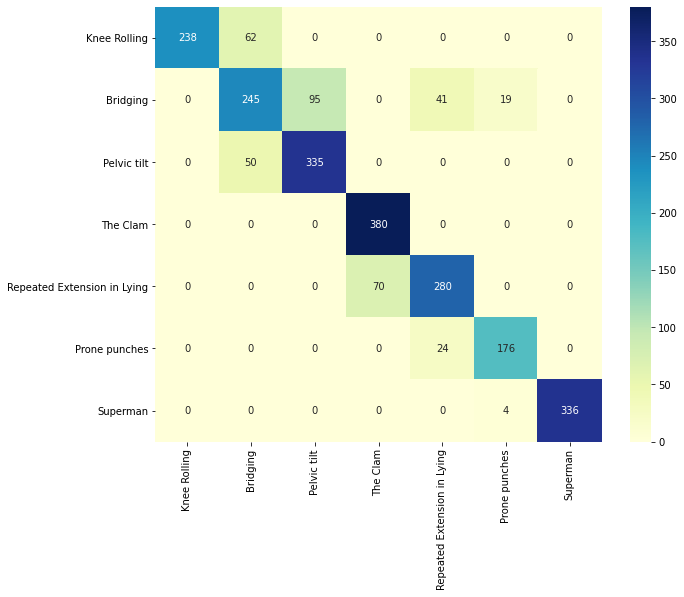

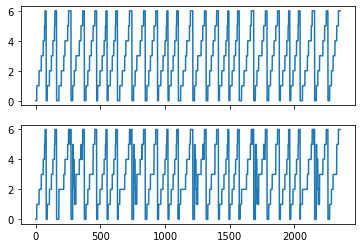

test subjects {6, 7, 8, 9, 10}
train subjects {1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
                             precision    recall  f1-score   support

               Knee Rolling       0.93      0.89      0.91       305
                   Bridging       0.97      0.47      0.63       370
                Pelvic tilt       0.68      0.99      0.80       445
                   The Clam       1.00      1.00      1.00       245
Repeated Extension in Lying       0.87      0.83      0.85       315
              Prone punches       0.81      0.85      0.83       270
                   Superman       1.00      1.00      1.00       345

                   accuracy                           0.86      2295
                  macro avg       0.89      0.86      0.86      2295
               weighted avg       0.88      0.86      0.85      2295



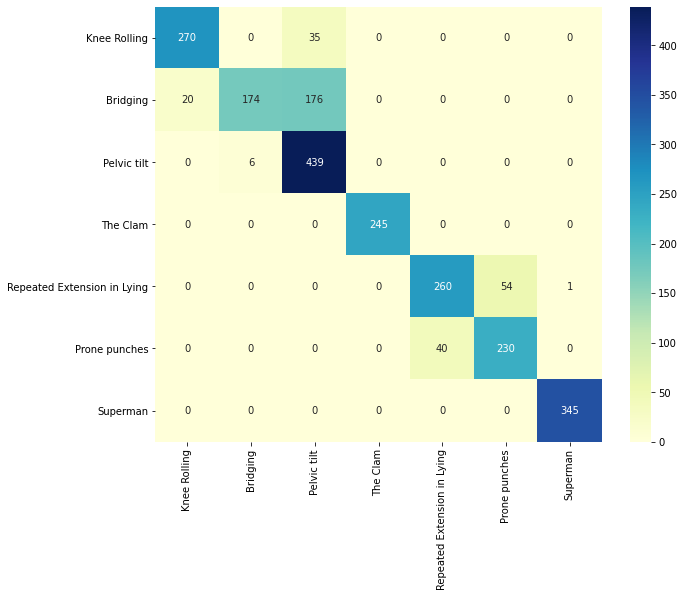

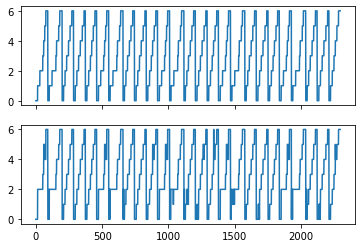

test subjects {11, 12, 13, 14, 15}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
                             precision    recall  f1-score   support

               Knee Rolling       0.99      0.57      0.72       330
                   Bridging       0.83      0.35      0.49       335
                Pelvic tilt       1.00      0.42      0.59       330
                   The Clam       0.60      0.97      0.74       475
Repeated Extension in Lying       0.46      0.78      0.58       315
              Prone punches       0.97      1.00      0.98       315
                   Superman       1.00      1.00      1.00       320

                   accuracy                           0.74      2420
                  macro avg       0.84      0.73      0.73      2420
               weighted avg       0.82      0.74      0.73      2420



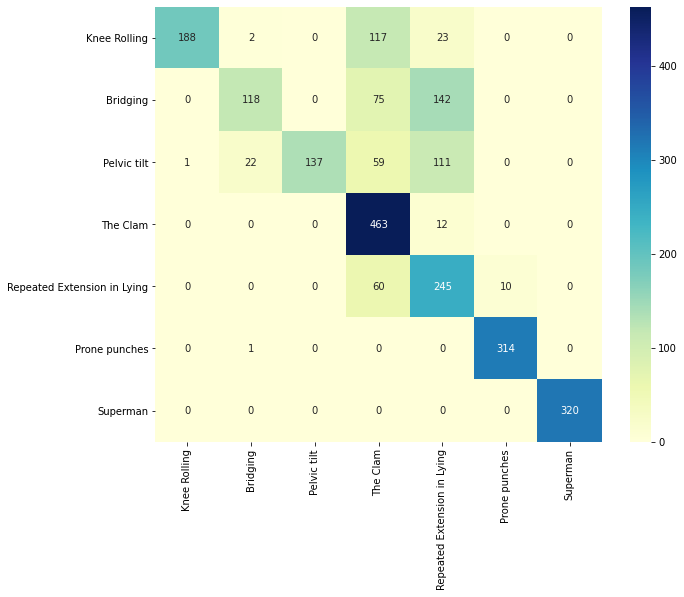

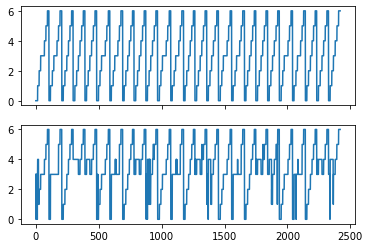

test subjects {16, 17, 18, 19, 20}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
                             precision    recall  f1-score   support

               Knee Rolling       1.00      0.96      0.98       320
                   Bridging       0.92      1.00      0.96       340
                Pelvic tilt       1.00      0.96      0.98       335
                   The Clam       1.00      0.99      0.99       330
Repeated Extension in Lying       0.80      0.81      0.80       335
              Prone punches       0.80      0.80      0.80       330
                   Superman       1.00      0.98      0.99       320

                   accuracy                           0.93      2310
                  macro avg       0.93      0.93      0.93      2310
               weighted avg       0.93      0.93      0.93      2310



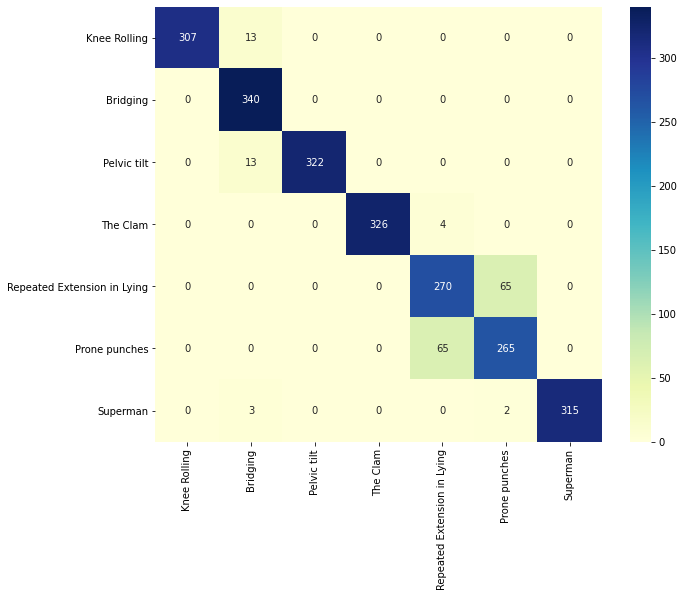

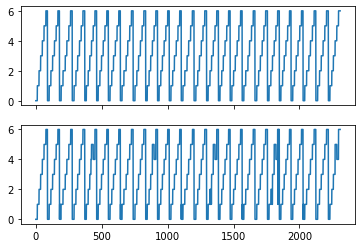

test subjects {21, 22, 23, 24, 25}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 28, 29, 30}
                             precision    recall  f1-score   support

               Knee Rolling       0.65      1.00      0.79       335
                   Bridging       0.69      0.42      0.52       335
                Pelvic tilt       0.74      0.52      0.61       325
                   The Clam       0.87      0.95      0.91       330
Repeated Extension in Lying       0.96      0.67      0.79       340
              Prone punches       0.78      0.93      0.85       335
                   Superman       0.85      1.00      0.92       325

                   accuracy                           0.78      2325
                  macro avg       0.79      0.78      0.77      2325
               weighted avg       0.79      0.78      0.77      2325



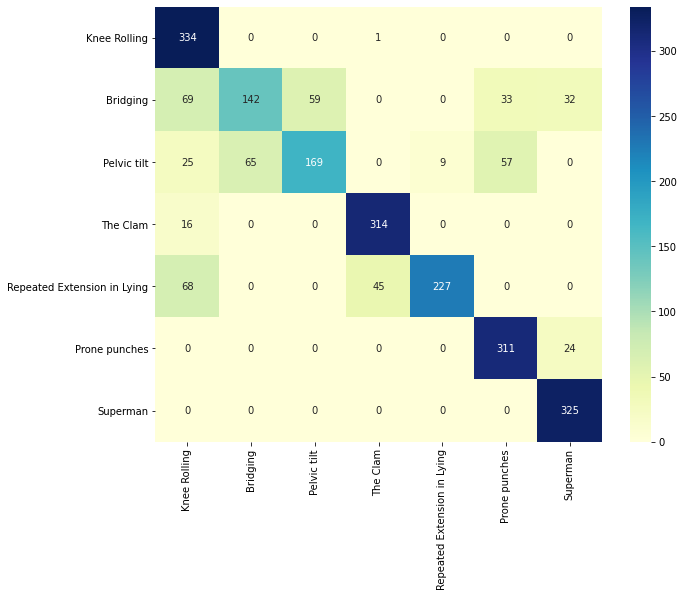

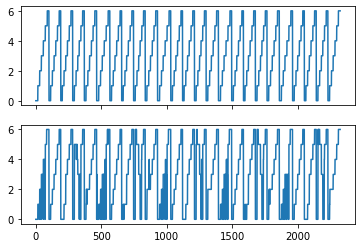

test subjects {26, 27, 28, 29, 30}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}


In [ ]:
run_experiment()

In [ ]:
run_experiment()

In [ ]:
run_experiment()

In [ ]:
run_experiment(N_WINDOW = 4, N_TIMESTEP = 500)

## LOSO

In [ ]:
def run_loso_experiment(N_WINDOW = 20, N_TIMESTEP = 75, BATCH_SIZE = 32):

    full_sub = list(range(1,31))
    SHUFFLE_BUFFER_SIZE = 1024
    for i in range(25, 31):
        test_sub = [i]
        train_sub = full_sub.copy()
        train_sub.remove(i)
        print('test subjects', test_sub)
        print('train subjects', train_sub)
        train_df = df[df['subject_id'].isin(train_sub)]
        test_df = df[df['subject_id'].isin(test_sub)]

        X_train, y_train = create_windowed_dataset(train_df, window_size=2000, stride = 300)
        X_test, y_test = create_windowed_dataset(test_df, window_size=2000, stride = 300)

        X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 6))
        X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 6))

        y_train = tf.keras.utils.to_categorical(y_train-1)
        y_test = tf.keras.utils.to_categorical(y_test-1)

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

        train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
        test_dataset = test_dataset.batch(BATCH_SIZE)

        model = HARModel(num_classes=7, n_window=N_WINDOW, n_timesteps=N_TIMESTEP,
                 d_model=64, num_heads=4, dff=256, expand_dim_factor=1, dropout_rate=0.2)
        tf.keras.backend.clear_session()
        model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    metrics=['accuracy'])
        model.fit(train_dataset, epochs=50, verbose=0)
        pred = model.predict(test_dataset)
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), zero_division=1))
        confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
        activity_list = list(activity_map.values())
        df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
        plt.figure(figsize = (10,8))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
        plt.show()


In [ ]:
run_loso_experiment(N_WINDOW = 25, N_TIMESTEP = 80, BATCH_SIZE = 128)

In [ ]:
run_loso_experiment(N_WINDOW = 25, N_TIMESTEP = 80, BATCH_SIZE = 128)

In [ ]:
FEATURES = ['act_x', 'act_y', 'act_z','acw_x', 'acw_y', 'acw_z']
FEATURES_THIGH = ['act_x', 'act_y', 'act_z']
FEATURES_WRIST = ['acw_x', 'acw_y', 'acw_z']
LABELS = 'activity'

In [ ]:
def run_loso_experiment_thigh(N_WINDOW = 20, N_TIMESTEP = 75, BATCH_SIZE = 32):

    full_sub = list(range(1,31))
    SHUFFLE_BUFFER_SIZE = 1024
    for i in range(1, 31):
        test_sub = [i]
        train_sub = full_sub.copy()
        train_sub.remove(i)
        print('test subjects', test_sub)
        print('train subjects', train_sub)
        train_df = df[df['subject_id'].isin(train_sub)]
        test_df = df[df['subject_id'].isin(test_sub)]

        X_train, y_train = create_windowed_dataset(train_df, FEATURES_THIGH, window_size=2000, stride = 300)
        X_test, y_test = create_windowed_dataset(test_df, FEATURES_THIGH, window_size=2000, stride = 300)

        X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 3))
        X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 3))

        y_train = tf.keras.utils.to_categorical(y_train-1)
        y_test = tf.keras.utils.to_categorical(y_test-1)

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

        train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
        test_dataset = test_dataset.batch(BATCH_SIZE)

        model = HARModel(num_classes=7, n_window=N_WINDOW, n_timesteps=N_TIMESTEP,
                 d_model=64, num_heads=4, dff=256, expand_dim_factor=1, dropout_rate=0.2)
        tf.keras.backend.clear_session()
        model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    metrics=['accuracy'])
        model.fit(train_dataset, epochs=50, verbose=0)
        pred = model.predict(test_dataset)
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), zero_division=1))
        confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
        activity_list = list(activity_map.values())
        df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
        plt.figure(figsize = (10,8))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
        plt.show()


In [ ]:
run_loso_experiment_thigh(N_WINDOW = 25, N_TIMESTEP = 80, BATCH_SIZE = 128)